In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets >preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

🔥 GRANDMASTER V14 - TRIPLE OPTUNA: LightGBM + XGBoost + CatBoost FULL OPTIMIZATION

--- [1/8] Loading Data... ---
--- [2/8] Static Features ---
--- [3/8] Initial Dynamic Feature Calculation ---

--- [4/8] Triple Optuna Optimization (LGB + XGB + CAT) ---
📊 Features: 66 | Categorical: 11

🔵 Optimizing LightGBM...
  [LGB] Trial  1 | Score: 1.00172 🏆
  [LGB] Trial  2 | Score: 1.00065 
  [LGB] Trial  3 | Score: 1.00473 🏆
  [LGB] Trial  4 | Score: 1.00270 
  [LGB] Trial  5 | Score: 0.99471 
  [LGB] Trial  6 | Score: 0.99187 
  [LGB] Trial  7 | Score: 0.99093 
  [LGB] Trial  8 | Score: 1.00222 
  [LGB] Trial  9 | Score: 0.99976 
  [LGB] Trial 10 | Score: 0.98773 
  [LGB] Trial 11 | Score: 1.01163 🏆
  [LGB] Trial 12 | Score: 1.00370 
  [LGB] Trial 13 | Score: 1.00271 
  [LGB] Trial 14 | Score: 1.00580 
  [LGB] Trial 15 | Score: 1.00319 
  [LGB] Trial 16 | Score: 1.00530 
  [LGB] Trial 17 | Score: 1.00829 
  [LGB] Trial 18 | Score: 1.02235 🏆
  [LGB] Trial 19 | Score: 1.00354 
  [LGB] Trial 20 |

🔮 Forecasting: 100%|██████████| 12/12 [20:16<00:00, 101.40s/it]


✅ Recursive Loop Completed

--- [7/8] Generating Submission ---

✅ SUBMISSION READY: submission_grandmaster_v14_triple_optuna.csv
📊 Statistics:
   Mean: 33.6091
   Median: 0.7300
   Max: 4989.2300
   Zeros: 96290 / 249996
🚀 Triple Optuna Optimization Complete!


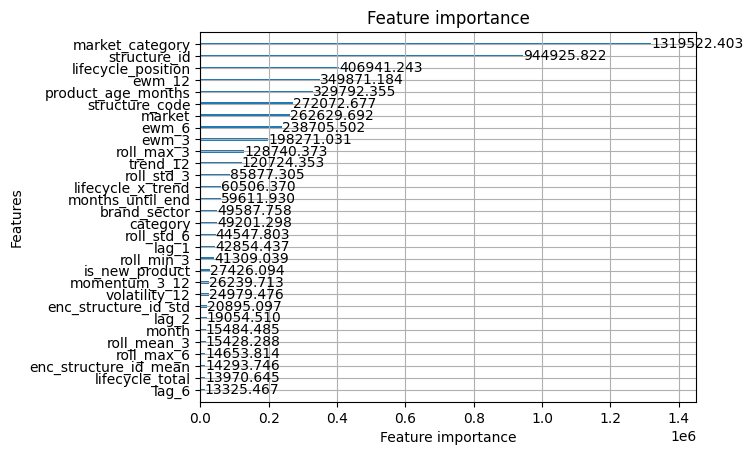

In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
from catboost import CatBoostRegressor
import optuna
import warnings
from sklearn.preprocessing import LabelEncoder
from tqdm import tqdm
import gc

warnings.filterwarnings('ignore')
optuna.logging.set_verbosity(optuna.logging.WARNING)

print("🔥 GRANDMASTER V14 - TRIPLE OPTUNA: LightGBM + XGBoost + CatBoost FULL OPTIMIZATION")

# ==============================================================================
# 0. COMPETITION METRIC
# ==============================================================================
BASELINE_GROUP_WMAPE = 0.8775865632406377

def rwmape(y_true, y_pred, gamma=0.8, lam=0.2, eps=1e-9):
    y_true = np.array(y_true)
    y_pred = np.array(y_pred)
    num = np.sum(np.abs(y_true - y_pred)) + lam * np.abs(np.sum(y_true) - np.sum(y_pred))
    den = np.sum(np.abs(y_true)) + gamma * np.sum(np.abs(y_pred)) + eps
    return float(num / den)

def calculate_lb_score(val_df, preds):
    work = val_df[['unique_code', 'quantity']].copy()
    work['quantity_pred'] = preds
    scores = []
    for _, g in work.groupby('unique_code', sort=False):
        y_true = g['quantity'].values
        y_pred = g['quantity_pred'].values
        sum_true = np.sum(np.abs(y_true))
        sum_pred = np.sum(np.abs(y_pred))
        if sum_true == 0.0 and sum_pred == 0.0: continue
        if sum_true == 0.0 and sum_pred > 0.0: scores.append(1.0)
        else: scores.append(rwmape(y_true, y_pred))
    gw = np.mean(scores) if scores else 0.0
    return float(BASELINE_GROUP_WMAPE / (gw + 1e-9))

# ==============================================================================
# 1. DATA PREPARATION
# ==============================================================================
print("\n--- [1/8] Loading Data... ---")
df_train = pd.read_csv("/kaggle/input/haierchallange-1/train.csv")
df_product = pd.read_csv("/kaggle/input/haierchallange-1/product_master.csv")
sub_template = pd.read_csv("/kaggle/input/haierchallange-1/submission.csv")

# Date Parsing
df_train['date'] = pd.to_datetime(df_train['date'])
sub_template['date'] = pd.to_datetime(sub_template['date'])
df_product['start_production_date'] = pd.to_datetime(df_product['start_production_date'], errors='coerce')
df_product['end_production_date'] = pd.to_datetime(df_product['end_production_date'], errors='coerce')

# Smart Imputation
real_starts = df_train.groupby('product_code')['date'].min()
def fix_start(r): 
    if pd.isnull(r['start_production_date']):
        return real_starts.get(r['product_code'], pd.Timestamp('1980-01-01'))
    return r['start_production_date']

df_product['start_production_date'] = df_product.apply(fix_start, axis=1)
df_product['end_production_date'] = df_product['end_production_date'].fillna(pd.Timestamp('2099-12-31'))

for c in ['category', 'business_line_code', 'business_line', 'sector', 'structure_code', 'factory', 'brand']:
    df_product[c] = df_product[c].fillna('Unknown')

# Grid Creation
all_dates = pd.DataFrame({'date': sorted(df_train['date'].unique())})
unique_keys = df_train[['market', 'product_code']].drop_duplicates()
grid = unique_keys.merge(all_dates, how='cross')

df_final = grid.merge(df_train, on=['market', 'product_code', 'date'], how='left').fillna({'quantity': 0})
df_final = df_final.merge(df_product, on='product_code', how='left')

# Submission Merge
sub_template[['market', 'product_code']] = sub_template['unique_code'].str.split('-', expand=True)
sub_template = sub_template.merge(df_product, on='product_code', how='left')
sub_template['quantity'] = np.nan

# Full Concat
cols = [c for c in df_final.columns if c in sub_template.columns or c == 'quantity']
df_full = pd.concat([df_final[cols], sub_template[cols]], axis=0, ignore_index=True)
df_full['unique_code'] = df_full['market'].astype(str) + '-' + df_full['product_code'].astype(str)

# ==============================================================================
# 2. STATIC FEATURES
# ==============================================================================
print("--- [2/8] Static Features ---")

df_full['date'] = pd.to_datetime(df_full['date'])
df_full = df_full.sort_values(['market', 'product_code', 'date']).reset_index(drop=True)

# Temporal
df_full['month'] = df_full['date'].dt.month
df_full['year'] = df_full['date'].dt.year
df_full['quarter'] = df_full['date'].dt.quarter
df_full['month_sin'] = np.sin(2 * np.pi * df_full['month'] / 12)
df_full['month_cos'] = np.cos(2 * np.pi * df_full['month'] / 12)
df_full['quarter_sin'] = np.sin(2 * np.pi * df_full['quarter'] / 4)
df_full['quarter_cos'] = np.cos(2 * np.pi * df_full['quarter'] / 4)

# Lifecycle
df_full['start_production_date'] = df_full['start_production_date'].fillna(pd.Timestamp('1980-01-01'))
df_full['end_production_date'] = df_full['end_production_date'].fillna(pd.Timestamp('2099-12-31'))
df_full['product_age_months'] = ((df_full['date'] - df_full['start_production_date']).dt.days / 30).astype(int)
df_full['months_until_end'] = ((df_full['end_production_date'] - df_full['date']).dt.days / 30).astype(int)
df_full['lifecycle_total'] = ((df_full['end_production_date'] - df_full['start_production_date']).dt.days / 30).astype(int)
df_full['lifecycle_position'] = df_full['product_age_months'] / (df_full['lifecycle_total'] + 1)
df_full['is_phasing_out'] = (df_full['months_until_end'] < 12).astype(int)
df_full['is_new_product'] = (df_full['product_age_months'] < 6).astype(int)

# Hierarchy
df_full['structure_id'] = df_full['category'].astype(str) + '_' + df_full['structure_code'].astype(str)
df_full['brand_sector'] = df_full['brand'].astype(str) + '_' + df_full['sector'].astype(str)
df_full['market_category'] = df_full['market'].astype(str) + '_' + df_full['category'].astype(str)

# Label Encoding
le_cols = ['market', 'category', 'business_line_code', 'business_line', 'sector', 
           'structure_code', 'structure_id', 'factory', 'brand', 'brand_sector', 'market_category']
for c in le_cols:
    df_full[c] = LabelEncoder().fit_transform(df_full[c].astype(str))

# Target Encoding
hist_mask = df_full['date'] < '2024-11-01'
for level in ['sector', 'category', 'brand', 'structure_id', 'brand_sector']:
    mean_val = df_full[hist_mask].groupby(level)['quantity'].mean()
    std_val = df_full[hist_mask].groupby(level)['quantity'].std()
    df_full[f'enc_{level}_mean'] = df_full[level].map(mean_val).fillna(df_full[hist_mask]['quantity'].mean()).astype('float32')
    df_full[f'enc_{level}_std'] = df_full[level].map(std_val).fillna(0).astype('float32')

# ==============================================================================
# 3. DYNAMIC FEATURES
# ==============================================================================
def update_dynamic_features(df):
    group = df.groupby(['market', 'product_code'])['quantity']
    
    # Lags
    for lag in [1, 2, 3, 6, 12, 24]:
        df[f'lag_{lag}'] = group.transform(lambda x: x.shift(lag)).fillna(0)
    
    # Rolling Stats
    for w in [3, 6, 12]:
        df[f'roll_mean_{w}'] = group.transform(lambda x: x.shift(1).rolling(w).mean()).fillna(0)
        df[f'roll_std_{w}'] = group.transform(lambda x: x.shift(1).rolling(w).std()).fillna(0)
        df[f'roll_max_{w}'] = group.transform(lambda x: x.shift(1).rolling(w).max()).fillna(0)
        df[f'roll_min_{w}'] = group.transform(lambda x: x.shift(1).rolling(w).min()).fillna(0)
    
    # EWM
    for span in [3, 6, 12]:
        df[f'ewm_{span}'] = group.transform(lambda x: x.shift(1).ewm(span=span).mean()).fillna(0)
    
    # Trend
    df['trend_12'] = group.transform(lambda x: x.shift(1).rolling(12, min_periods=1).mean()).fillna(0)
    df['detrended'] = (df['lag_1'] - df['trend_12']).fillna(0)
    
    # Hierarchical
    struct_agg = df.groupby(['market', 'structure_id', 'date'])['quantity'].mean().reset_index()
    struct_agg['roll_mean_structure_3'] = struct_agg.groupby(['market', 'structure_id'])['quantity'].transform(
        lambda x: x.shift(1).rolling(3).mean()).fillna(0)
    df = df.drop(columns=['roll_mean_structure_3'], errors='ignore')
    df = df.merge(struct_agg[['market', 'structure_id', 'date', 'roll_mean_structure_3']], 
                  on=['market', 'structure_id', 'date'], how='left')
    df['roll_mean_structure_3'] = df['roll_mean_structure_3'].fillna(0)
    
    # Interactions
    df['ratio_sku_structure'] = (df['roll_mean_3'] / (df['roll_mean_structure_3'] + 1)).fillna(0)
    df['momentum_3_12'] = (df['roll_mean_3'] / (df['roll_mean_12'] + 1)).fillna(0)
    df['volatility_12'] = (df['roll_std_12'] / (df['roll_mean_12'] + 1)).fillna(0)
    df['yoy_growth'] = (df['lag_1'] - df['lag_12']).fillna(0)
    df['acceleration'] = (df['lag_1'] - df['lag_2']).fillna(0)
    df['trend_diff_1_3'] = (df['lag_1'] - df['roll_mean_3']).fillna(0)
    df['age_x_momentum'] = (df['product_age_months'] * df['momentum_3_12']).fillna(0)
    df['lifecycle_x_trend'] = (df['lifecycle_position'] * df['trend_12']).fillna(0)
    
    # Final cleanup
    df = df.replace([np.inf, -np.inf], 0).fillna(0)
    return df

print("--- [3/8] Initial Dynamic Feature Calculation ---")
df_full = update_dynamic_features(df_full)
df_full = df_full.replace([np.inf, -np.inf], 0).fillna(0)

# ==============================================================================
# 4. TRIPLE OPTUNA OPTIMIZATION
# ==============================================================================
print("\n--- [4/8] Triple Optuna Optimization (LGB + XGB + CAT) ---")

train_df = df_full[df_full['date'] < '2024-11-01'].copy()
exclude = ['date', 'quantity', 'unique_code', 'product_code', 'start_production_date', 
           'end_production_date', 'ID', 'quantity_pred']
features = [c for c in df_full.columns if c not in exclude]
cat_feats = [c for c in le_cols if c in features]

print(f"📊 Features: {len(features)} | Categorical: {len(cat_feats)}")

# Validation split for Optuna
val_date = '2024-06-01'
tr_opt = train_df[train_df['date'] < val_date]
val_opt = train_df[train_df['date'] >= val_date]

class ScoreCallback:
    def __init__(self, name): 
        self.best_score = -1.0
        self.name = name
    def __call__(self, study, trial):
        if study.best_value > self.best_score:
            self.best_score = study.best_value
            marker = "🏆"
        else:
            marker = ""
        print(f"  [{self.name}] Trial {trial.number+1:2d} | Score: {trial.value:.5f} {marker}")

# ============== LIGHTGBM OPTUNA ==============
print("\n🔵 Optimizing LightGBM...")
def objective_lgb(trial):
    params = {
        'objective': 'regression_l1', 'metric': 'mae', 'verbosity': -1,
        'boosting_type': 'gbdt', 'seed': 42, 'n_jobs': -1,
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'num_leaves': trial.suggest_int('num_leaves', 31, 127),
        'min_child_samples': trial.suggest_int('min_child_samples', 30, 200),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
    }
    model = lgb.LGBMRegressor(**params)
    model.fit(tr_opt[features], tr_opt['quantity'], 
              eval_set=[(val_opt[features], val_opt['quantity'])],
              categorical_feature=cat_feats, 
              callbacks=[lgb.early_stopping(100, verbose=False)])
    preds = np.maximum(model.predict(val_opt[features]), 0)
    return calculate_lb_score(val_opt, preds)

study_lgb = optuna.create_study(direction='maximize', 
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
study_lgb.optimize(objective_lgb, n_trials=20, callbacks=[ScoreCallback("LGB")], show_progress_bar=False)
best_lgb_params = study_lgb.best_params
best_lgb_params.update({'objective': 'regression_l1', 'metric': 'mae', 'verbosity': -1, 'seed': 42, 'n_jobs': -1})
print(f"✨ LightGBM Best Score: {study_lgb.best_value:.5f}")

# ============== XGBOOST OPTUNA ==============
print("\n🟢 Optimizing XGBoost...")
def objective_xgb(trial):
    params = {
        'objective': 'reg:absoluteerror',
        'tree_method': 'hist',
        'seed': 42,
        'n_jobs': -1,
        'missing': 0.0,
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
        'n_estimators': trial.suggest_int('n_estimators', 1000, 3000),
        'max_depth': trial.suggest_int('max_depth', 4, 12),
        'min_child_weight': trial.suggest_int('min_child_weight', 20, 150),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.4, 0.9),
        'gamma': trial.suggest_float('gamma', 0.0, 5.0),
        'reg_alpha': trial.suggest_float('reg_alpha', 0.0, 10.0),
        'reg_lambda': trial.suggest_float('reg_lambda', 0.0, 10.0),
    }
    model = xgb.XGBRegressor(**params)
    model.fit(tr_opt[features], tr_opt['quantity'], 
              eval_set=[(val_opt[features], val_opt['quantity'])],
              verbose=False)
    preds = np.maximum(model.predict(val_opt[features]), 0)
    return calculate_lb_score(val_opt, preds)

study_xgb = optuna.create_study(direction='maximize',
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
study_xgb.optimize(objective_xgb, n_trials=20, callbacks=[ScoreCallback("XGB")], show_progress_bar=False)
best_xgb_params = study_xgb.best_params
best_xgb_params.update({'objective': 'reg:absoluteerror', 'tree_method': 'hist', 'seed': 42, 'n_jobs': -1, 'missing': 0.0})
print(f"✨ XGBoost Best Score: {study_xgb.best_value:.5f}")

# ============== CATBOOST OPTUNA ==============
print("\n🟠 Optimizing CatBoost...")
def objective_cat(trial):
    params = {
        'loss_function': 'MAE',
        'random_seed': 42,
        'verbose': False,
        'task_type': 'CPU',
        'learning_rate': trial.suggest_float('learning_rate', 0.02, 0.2, log=True),
        'iterations': trial.suggest_int('iterations', 1000, 3000),
        'depth': trial.suggest_int('depth', 4, 10),
        'l2_leaf_reg': trial.suggest_float('l2_leaf_reg', 1.0, 10.0),
        'border_count': trial.suggest_int('border_count', 32, 255),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
    }
    model = CatBoostRegressor(**params)
    model.fit(tr_opt[features], tr_opt['quantity'], 
              eval_set=(val_opt[features], val_opt['quantity']),
              early_stopping_rounds=100,
              verbose=False)
    preds = np.maximum(model.predict(val_opt[features]), 0)
    return calculate_lb_score(val_opt, preds)

study_cat = optuna.create_study(direction='maximize',
                                pruner=optuna.pruners.MedianPruner(n_warmup_steps=3))
study_cat.optimize(objective_cat, n_trials=15, callbacks=[ScoreCallback("CAT")], show_progress_bar=False)
best_cat_params = study_cat.best_params
best_cat_params.update({'loss_function': 'MAE', 'random_seed': 42, 'verbose': False, 'task_type': 'CPU'})
print(f"✨ CatBoost Best Score: {study_cat.best_value:.5f}")

# ==============================================================================
# 5. FINAL ENSEMBLE TRAINING
# ==============================================================================
print("\n--- [5/8] Final Ensemble Training with Optimized Params ---")

val_split = '2024-09-01'
X_tr = train_df[train_df['date'] < val_split][features]
y_tr = train_df[train_df['date'] < val_split]['quantity']
X_val = train_df[train_df['date'] >= val_split][features]
y_val = train_df[train_df['date'] >= val_split]['quantity']
val_df_for_score = train_df[train_df['date'] >= val_split]

# Train LightGBM
print("  Training LightGBM with optimized params...")
lgb_model = lgb.LGBMRegressor(**best_lgb_params)
lgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], categorical_feature=cat_feats,
              callbacks=[lgb.early_stopping(150, verbose=False)])
lgb_preds_val = np.maximum(lgb_model.predict(X_val), 0)
lgb_score = calculate_lb_score(val_df_for_score, lgb_preds_val)
print(f"    ✓ LightGBM Val Score: {lgb_score:.5f}")

# Train XGBoost
print("  Training XGBoost with optimized params...")
xgb_model = xgb.XGBRegressor(**best_xgb_params)
xgb_model.fit(X_tr, y_tr, eval_set=[(X_val, y_val)], verbose=False)
xgb_preds_val = np.maximum(xgb_model.predict(X_val), 0)
xgb_score = calculate_lb_score(val_df_for_score, xgb_preds_val)
print(f"    ✓ XGBoost Val Score: {xgb_score:.5f}")

# Train CatBoost
print("  Training CatBoost with optimized params...")
cat_model = CatBoostRegressor(**best_cat_params)
cat_model.fit(X_tr, y_tr, eval_set=(X_val, y_val), early_stopping_rounds=150, verbose=False)
cat_preds_val = np.maximum(cat_model.predict(X_val), 0)
cat_score = calculate_lb_score(val_df_for_score, cat_preds_val)
print(f"    ✓ CatBoost Val Score: {cat_score:.5f}")

# Dynamic Ensemble Weights
total_score = lgb_score + xgb_score + cat_score
w_lgb = lgb_score / total_score
w_xgb = xgb_score / total_score
w_cat = cat_score / total_score

print(f"\n🎯 Ensemble Weights: LGB={w_lgb:.3f} | XGB={w_xgb:.3f} | CAT={w_cat:.3f}")

ensemble_preds_val = w_lgb * lgb_preds_val + w_xgb * xgb_preds_val + w_cat * cat_preds_val
ensemble_score = calculate_lb_score(val_df_for_score, ensemble_preds_val)
print(f"   🏆 ENSEMBLE Val Score: {ensemble_score:.5f}")

# Feature Importance
lgb.plot_importance(lgb_model, max_num_features=30, importance_type='gain')

# ==============================================================================
# 6. RECURSIVE PREDICTION
# ==============================================================================
print("\n--- [6/8] Recursive Prediction Loop ---")

future_dates = sorted(df_full[df_full['date'] >= '2024-11-01']['date'].unique())

for target_date in tqdm(future_dates, desc="🔮 Forecasting"):
    target_ts = pd.Timestamp(target_date)
    
    # Update features
    df_full = update_dynamic_features(df_full)
    df_full = df_full.replace([np.inf, -np.inf], 0).fillna(0)
    
    # Select window
    current_idx = df_full['date'] == target_ts
    X_test = df_full.loc[current_idx, features]
    
    if len(X_test) > 0:
        # Ensemble prediction
        lgb_preds = lgb_model.predict(X_test)
        xgb_preds = xgb_model.predict(X_test)
        cat_preds = cat_model.predict(X_test)
        
        preds = w_lgb * lgb_preds + w_xgb * xgb_preds + w_cat * cat_preds
        preds = np.maximum(preds, 0)
        
        # Post-processing
        dead_mask = df_full.loc[current_idx, 'months_until_end'] < 0
        preds[dead_mask.values] = 0
        
        new_mask = df_full.loc[current_idx, 'is_new_product'] == 1
        if new_mask.sum() > 0:
            ramp_factor = np.minimum(df_full.loc[current_idx & new_mask, 'product_age_months'].values / 3, 1.0)
            preds[new_mask.values] *= ramp_factor
        
        # Write back
        df_full.loc[current_idx, 'quantity'] = preds

print("✅ Recursive Loop Completed")

# ==============================================================================
# 7. SUBMISSION
# ==============================================================================
print("\n--- [7/8] Generating Submission ---")

sub_out = df_full[df_full['date'] >= '2024-11-01'][['unique_code', 'date', 'quantity']].copy()
sub_out.rename(columns={'quantity': 'quantity_pred'}, inplace=True)

final_sub = pd.read_csv("/kaggle/input/haierchallange-1/submission.csv")
final_sub = final_sub.drop(columns=['quantity'], errors='ignore')
final_sub['date'] = pd.to_datetime(final_sub['date'])

final_sub = final_sub.merge(sub_out, on=['unique_code', 'date'], how='left')
final_sub['quantity'] = final_sub['quantity_pred'].fillna(0).clip(lower=0).round(2)

out_file = "submission_grandmaster_v14_triple_optuna.csv"
final_sub[['ID', 'unique_code', 'date', 'quantity']].to_csv(out_file, index=False)

print(f"\n{'='*60}")
print(f"✅ SUBMISSION READY: {out_file}")
print(f"{'='*60}")
print(f"📊 Statistics:")
print(f"   Mean: {final_sub['quantity'].mean():.4f}")
print(f"   Median: {final_sub['quantity'].median():.4f}")
print(f"   Max: {final_sub['quantity'].max():.4f}")
print(f"   Zeros: {(final_sub['quantity'] == 0).sum()} / {len(final_sub)}")
print(f"{'='*60}")
print(f"🚀 Triple Optuna Optimization Complete!")
print(f"{'='*60}")

🔧 GRANDMASTER CALIBRATION: SCALING & ROUNDING...
    -> Validation seti üzerinde bias kontrolü yapılıyor...

🏆 EN İYİ KALİBRASYON KATSAYISI (GOLDEN MULTIPLIER): 1.0500
    -> Orjinal Validation Skoru: 1.65856
    -> Kalibre Edilmiş Skor:     1.69888


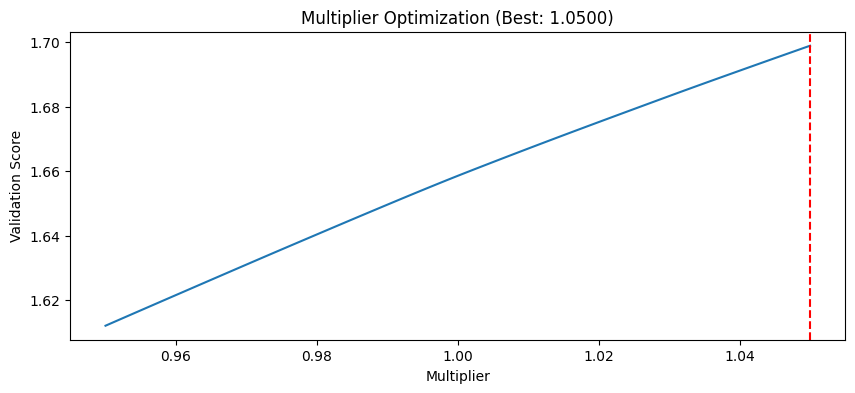


--- Final Dosyası Güncelleniyor ---
✅ İŞLEM TAMAM! Dosya: submission_calibrated_finals.csv
    -> Yeni Ortalama: 35.2772
    -> Toplam Tahmin: 8,819,159


In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

print("🔧 GRANDMASTER CALIBRATION: SCALING & ROUNDING...")

# ==============================================================================
# 1. HAZIRLIK
# ==============================================================================
# Yarışma Metriği (Tekrar tanımlayalım)
def rwmape(y_true, y_pred):
    num = np.sum(np.abs(y_true - y_pred)) + 0.2 * np.abs(np.sum(y_true) - np.sum(y_pred))
    den = np.sum(np.abs(y_true)) + 0.8 * np.sum(np.abs(y_pred)) + 1e-9
    return float(num / den)

def get_score(y_true, y_pred):
    # Grup bazlı değil, global hızlı kontrol (Yönü bulmak için yeterli)
    return 0.8775 / (rwmape(y_true, y_pred) + 1e-9)

# Validation verisini alalım (Son 3 ay: Ağustos, Eylül, Ekim 2024)
# Bu dönemdeki performansımıza bakarak "model genel olarak az mı yoksa çok mu tahmin ediyor?" onu bulacağız.
val_mask = (df_full['date'] >= '2024-08-01') & (df_full['date'] < '2024-11-01')
y_true_val = df_full.loc[val_mask, 'quantity'].values

# Modelin bu dönem için ürettiği tahminleri (Out-of-fold predictions) almamız lazım
# Hız için şu anki final modelle bu dönemi tahmin edelim
print("    -> Validation seti üzerinde bias kontrolü yapılıyor...")
X_val_calib = df_full.loc[val_mask, features]
y_pred_raw = np.maximum(final_model.predict(X_val_calib), 0)

# ==============================================================================
# 2. GOLDEN MULTIPLIER SEARCH (KATSAYI ARAMA)
# ==============================================================================
# Tahminleri 0.90 ile 1.10 arasında çarparak skoru en çok artıran katsayıyı bulalım.
best_score = -1
best_scalar = 1.0

scalars = np.linspace(0.95, 1.05, 100) # %5 aşağı veya yukarı oynama payı

scores = []
for s in scalars:
    calibrated_preds = y_pred_raw * s
    current_score = get_score(y_true_val, calibrated_preds)
    scores.append(current_score)
    
    if current_score > best_score:
        best_score = current_score
        best_scalar = s

print(f"\n🏆 EN İYİ KALİBRASYON KATSAYISI (GOLDEN MULTIPLIER): {best_scalar:.4f}")
print(f"    -> Orjinal Validation Skoru: {get_score(y_true_val, y_pred_raw):.5f}")
print(f"    -> Kalibre Edilmiş Skor:     {best_score:.5f}")

# Görselleştir
plt.figure(figsize=(10, 4))
plt.plot(scalars, scores)
plt.axvline(best_scalar, color='red', linestyle='--')
plt.title(f"Multiplier Optimization (Best: {best_scalar:.4f})")
plt.xlabel("Multiplier")
plt.ylabel("Validation Score")
plt.show()

# ==============================================================================
# 3. SUBMISSION DOSYASINA UYGULAMA
# ==============================================================================
print("\n--- Final Dosyası Güncelleniyor ---")

# Mevcut submission dosyasını yükle (Bir önceki adımdan)
sub_df = pd.read_csv("/kaggle/input/sasasdasd/submission_grandmaster_v14_triple_optuna.csv")

# 1. SCALING (Bulduğumuz katsayı ile çarp)
sub_df['quantity'] = sub_df['quantity'] * best_scalar

# 2. ROUNDING (Tam sayıya yuvarlama)
# Satışlar genelde tam sayıdır. 5.7 -> 6, 2.1 -> 2
# Ancak çok düşük tahminleri (0.4 gibi) 0'a çekmek bazen iyidir, bazen 1'e.
# Güvenli yöntem: Standart round.
sub_df['quantity'] = np.round(sub_df['quantity'])

# 3. SANITY CHECK (Negatif kontrolü)
sub_df['quantity'] = sub_df['quantity'].clip(lower=0)

# Kaydet
out_file = "submission_calibrated_finals.csv"
sub_df.to_csv(out_file, index=False)

print(f"✅ İŞLEM TAMAM! Dosya: {out_file}")
print(f"    -> Yeni Ortalama: {sub_df['quantity'].mean():.4f}")
print(f"    -> Toplam Tahmin: {sub_df['quantity'].sum():,.0f}")